In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
NTURN = [128,256,512,1024,2048]

nCore_y = 8
nCore_z = 4

NL_c = 0.01
NL_t = 0.4
dTune = 0.0

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
betx = beam.distribution.betx
alfx = beam.distribution.alfx

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].strength_t = NL_t
lattice[1].pipe_radius = 0.02*np.sqrt(2)
lattice[2].tune_advance = dTune

### 1.2. generate particles

In [6]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
npt = len(pTest)
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 7668


In [7]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

In [8]:
TBT = impact.getElem('TBT')
lattice.insert(1,TBT)

OUTPUT = impact.getElem('write_raw_ptcl')
lattice.append(OUTPUT)

# FMA

### Run Forward 

In [9]:
lattice[0].turns = NTURN[0]
TBT.file_id = NTURN[0]
OUTPUT.file_id = -NTURN[0]
OUTPUT.turn = NTURN[0]
impact.writeInputFile(beam,lattice) 
# impact.run(beam)

In [10]:
for nturn in NTURN[:-1]:
    lattice[0].turns = nturn
    TBT.file_id = nturn*2
    OUTPUT.turn = nturn
    OUTPUT.file_id = -nturn*2
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,lattice) 
#     impact.run(beam)

### Load Data

In [11]:
iTBT = {}
TBT = {}
X = {}
Y = {}
Npt = {}

for nturn in NTURN:
    print(nturn)
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])

128
256
512
1024
2048


In [12]:
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn

0 128 128 7660 7660
0 128 256 7660 7660
128 256 256 7660 7660
0 128 512 7660 7660
128 256 512 7660 7660
256 512 512 7660 7660
0 128 1024 7660 7660
128 256 1024 7660 7660
256 512 1024 7660 7660
512 1024 1024 7660 7660
0 128 2048 7656 7656
128 256 2048 7656 7656
256 512 2048 7656 7656
512 1024 2048 7656 7656
1024 2048 2048 7656 7656


### Apply NAFF

In [13]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [14]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}

for nturn in NTURN[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        signal = X[nturn][:int(nturn/2),i] -np.mean(X[nturn][:int(nturn/2),i])
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = X[nturn][int(nturn/2):,i] -np.mean(X[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        
        signal = Y[nturn][:int(nturn/2),i] -np.mean(Y[nturn][:int(nturn/2),i])
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = Y[nturn][int(nturn/2):,i] -np.mean(Y[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
        
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

### Plot

##### FFT

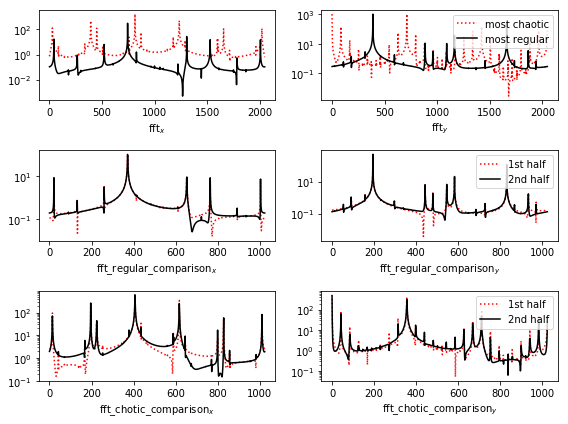

In [15]:
n=2048
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMin[n][1]])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMin[n][2]])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMin[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMin[n][1]])),'k')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMin[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMin[n][2]])),'k')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMax[n][1]])),'k')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMax[n][2]])),'k')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.mu='+str(dTune)+'.png',dpi=180)
# plt.close()

##### Tune Plot

In [16]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

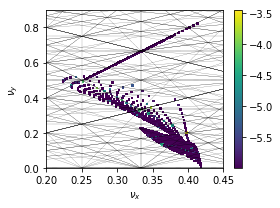

In [17]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=Adiff[n],s=2.0,marker='s')
    
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.2,0.45)
plt.ylim(0.0,0.9)
plt.tight_layout()
plt.savefig('FMA.tune.mu='+str(dTune)+'.png',dpi=180)
# plt.close()

##### Poincare

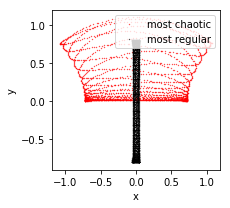

In [18]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.poincare.xy.mu='+str(dTune)+'.png',dpi=180)

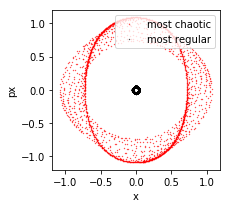

In [19]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.poincare.xpx.mu='+str(dTune)+'.png',dpi=180)

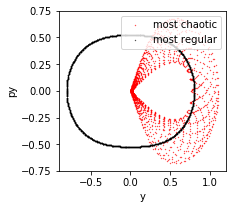

In [20]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.poincare.ypy.mu='+str(dTune)+'.png',dpi=180)

##### DA

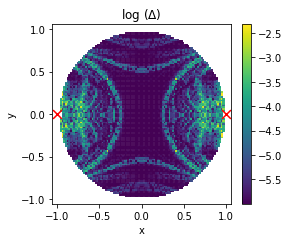

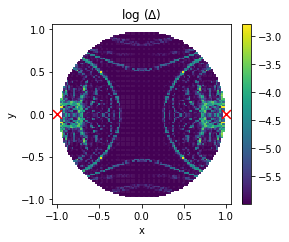

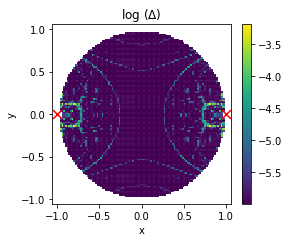

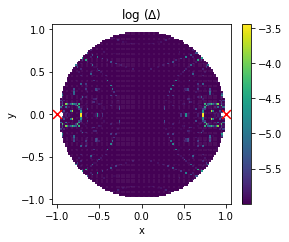

In [21]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in NTURN[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.mu='+str(dTune)+'.turn='+str(n/2)+'.png',dpi=180)

# FB

### Run Backward

In [22]:
lattice.pop()
latticeB = copy(lattice[1:][::-1])
latticeB.insert(0,copy(lattice[0]))

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        latticeB[i].tune_advance                 =-latticeB[i].tune_advance
        latticeB[i].nonlinear_insert_tuneAdvance =-latticeB[i].nonlinear_insert_tuneAdvance
        latticeB[i].nonlinear_insert_length      =-latticeB[i].nonlinear_insert_length

In [23]:
for nturn in NTURN[:-1]:
    latticeB[0].turns = nturn
    latticeB[-1].file_id = 100000+nturn
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,latticeB) 
#     impact.run(beam)

### Load Data

In [24]:
for nturn in NTURN[:-1]:
    print(nturn)
    iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn,ke,mass,freq)
    TBT[-nturn] = TBT[-nturn][:,:4,:]
    Npt[-nturn] = len(iTBT[-nturn])

128
256
512
1024


In [25]:
for i in range(len(NTURN)-1):
    nturn = NTURN[i]
    
    npt = len(iTBT[-nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    tmp = TBT[-nturn][::-1,:4,:]
    X[-nturn]=(tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
    Y[-nturn]=(tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn

0 128 128 7660 7660
0 128 256 7660 7660
128 256 256 7660 7660
0 128 512 7660 7660
128 256 512 7660 7660
256 512 512 7660 7660
0 128 1024 7660 7660
128 256 1024 7660 7660
256 512 1024 7660 7660
512 1024 1024 7660 7660


In [26]:
nturn = 256
iturn = 126
ipt = 100
print(X[nturn][iturn,ipt]-X[-nturn][iturn,ipt])

(1.7185119993712306e-09-2.5525596636377657e-09j)


In [27]:
for nturn in NTURN[:-1]:
    nturn = -nturn
    Xdiff[nturn] = np.abs(X[nturn]-X[-nturn])**2
    Ydiff[nturn] = np.abs(Y[nturn]-Y[-nturn])**2
    Adiff[nturn] = Xdiff[nturn] + Ydiff[nturn]
    Xdiff[nturn] = np.sqrt(-np.sum(Xdiff[nturn],0)/nturn)
    Ydiff[nturn] = np.sqrt(-np.sum(Ydiff[nturn],0)/nturn)
    Adiff[nturn] = np.sqrt(-np.sum(Adiff[nturn],0)/nturn)
    Xdiff[nturn] = np.log10(Xdiff[nturn])
    Ydiff[nturn] = np.log10(Ydiff[nturn])
    Adiff[nturn] = np.log10(Adiff[nturn])
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

### Plot

##### Poincare

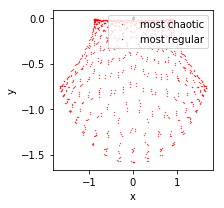

In [28]:
n=-1024
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.poincare.xy.mu='+str(dTune)+'.png',dpi=180)

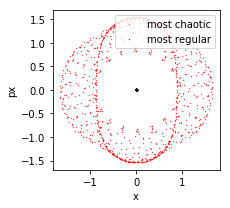

In [29]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.poincare.xpx.mu='+str(dTune)+'.png',dpi=180)

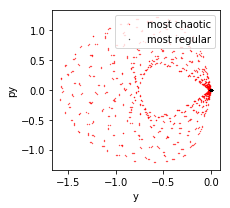

In [30]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.poincare.ypy.mu='+str(dTune)+'.png',dpi=180)

##### DA

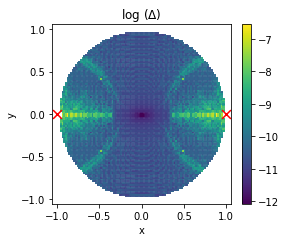

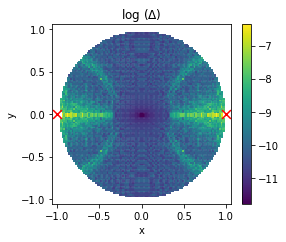

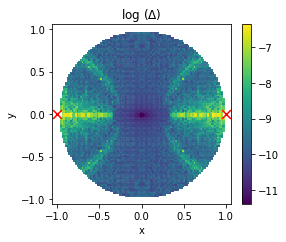

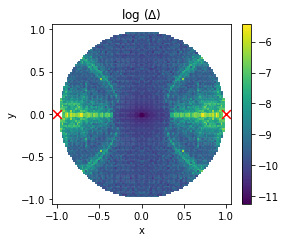

In [31]:
n=128
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in NTURN[:-1]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[-n],s=1.6,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.mu='+str(dTune)+'.turn='+str(n)+'.png',dpi=180)